# Food Delivery Time Prediction - Regression
Accurate delivery time estimation is crucial for food delivery platforms to ensure customer satisfaction and optimize logistics operations. By leveraging machine learning techniques, we can forecast delivery durations based on various factors that influence transit time. This notebook explores building a predictive model for food delivery times using regression analysis in Python.

<div align="center">
<img src="https://t4.ftcdn.net/jpg/03/94/73/73/360_F_394737308_A5IJf7vijvkGWCsiCcNI1kAGWoa5g54h.jpg">
</div>

## Understanding Delivery Time Prediction
The core challenge involves determining the expected delivery duration from restaurant to customer location. This requires analyzing the spatial relationship between pickup and drop-off points, along with identifying patterns in delivery performance for comparable routes.

For this analysis, we'll utilize a comprehensive dataset that captures delivery partner performance metrics, including travel times for different distances and conditions. The dataset contains all necessary features to train an effective prediction model. You can access the dataset from [here](I_will_put_link_here).

The following sections will guide you through implementing a machine learning solution for food delivery time prediction using Python.

## 1. Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import joblib
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import ExtraTreeRegressor, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from tqdm.notebook import tqdm
from sklearn.metrics import r2_score, mean_squared_error

import warnings

### Configuration
- Ignore warnings for cleaner output.
- Set default figure size to 12x8 inches for plots.
- Use seaborn's 'darkgrid' style for improved plot aesthetics.

In [2]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('darkgrid')

## 2. Load Dataset

In this section, we'll load the food delivery dataset that contains delivery information. The dataset is stored in a text file format with comma-separated values (CSV), making it easy to read using pandas' built-in CSV reader functionality.

**Dataset Overview:**
- **Format**: Text file (.txt) with comma-separated values
- **Content**: Food delivery records including delivery times, distances, and other relevant features
- **Purpose**: Training data for building a predictive model to estimate delivery times

The dataset will be loaded into a pandas DataFrame, which provides powerful data manipulation and analysis capabilities for our machine learning pipeline.

In [3]:
df = pd.read_csv('deliverytime.txt')

Let's display first 5 rows of the dataset

In [4]:
df.head()

ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0  4607     INDORES13DEL02                   37                      4.9   
1  B379     BANGRES18DEL02                   34                      4.5   
2  5D6D     BANGRES19DEL01                   23                      4.4   
3  7A6A    COIMBRES13DEL02                   38                      4.7   
4  70A2     CHENRES12DEL01                   32                      4.6   

   Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0            22.745049             75.892471                   22.765049   
1            12.913041             77.683237                   13.043041   
2            12.914264             77.678400                   12.924264   
3            11.003669             76.976494                   11.053669   
4            12.972793             80.249982                   13.012793   

   Delivery_location_longitude Type_of_order Type_of_vehicle  Time_taken(min)  
0                    75.912471        Snack      motorcycle                24  
1                    77.813237        Snack         scooter                33  
2                    77.688400       Drinks      motorcycle                26  
3                    77.026494       Buffet      motorcycle                21  
4                    80.289982        Snack         scooter                30

In [5]:
df.shape

(45593, 11)

Let’s have a look at the column insights

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  int64  
 3   Delivery_person_Ratings      45593 non-null  float64
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Type_of_order                45593 non-null  object 
 9   Type_of_vehicle              45593 non-null  object 
 10  Time_taken(min)              45593 non-null  int64  
dtypes: float64(5), int64(2), object(4)
memory usage: 3.8+ MB


Let's have a look at the numerical features

In [7]:
df.describe().T

count       mean        std        min  \
Delivery_person_Age          45593.0  29.544075   5.696793  15.000000   
Delivery_person_Ratings      45593.0   4.632367   0.327708   1.000000   
Restaurant_latitude          45593.0  17.017729   8.185109 -30.905562   
Restaurant_longitude         45593.0  70.231332  22.883647 -88.366217   
Delivery_location_latitude   45593.0  17.465186   7.335122   0.010000   
Delivery_location_longitude  45593.0  70.845702  21.118812   0.010000   
Time_taken(min)              45593.0  26.294607   9.383806  10.000000   

                                   25%        50%        75%        max  
Delivery_person_Age          25.000000  29.000000  34.000000  50.000000  
Delivery_person_Ratings       4.600000   4.700000   4.800000   6.000000  
Restaurant_latitude          12.933284  18.546947  22.728163  30.914057  
Restaurant_longitude         73.170000  75.898497  78.044095  88.433452  
Delivery_location_latitude   12.988453  18.633934  22.785049  31.054057  
Delivery_location_longitude  73.280000  76.002574  78.107044  88.563452  
Time_taken(min)              19.000000  26.000000  32.000000  54.000000

Now let's check for missing values

In [8]:
df.isnull().sum()

ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Type_of_order                  0
Type_of_vehicle                0
Time_taken(min)                0
dtype: int64

The dataset contains 45,593 complete records with no missing values.

## 3. Exploratory Data Analysis (EDA)
We'll analyze the delivery dataset to uncover patterns in delivery times, distance relationships, and key factors affecting transit duration. This includes examining data distributions, correlations, and identifying potential outliers that could impact our prediction model.

Let's have a look at the relationship between delivery person ratings and delivery time

In [9]:
px.scatter(
    df,
    x='Delivery_person_Ratings',
    y='Time_taken(min)',
    hover_name='Delivery_person_ID',
    color='Type_of_vehicle',
    title='Delivery Time vs Delivery Person Ratings'
)

Now let's display the relationship between type of vehicle and delivery time with type of order

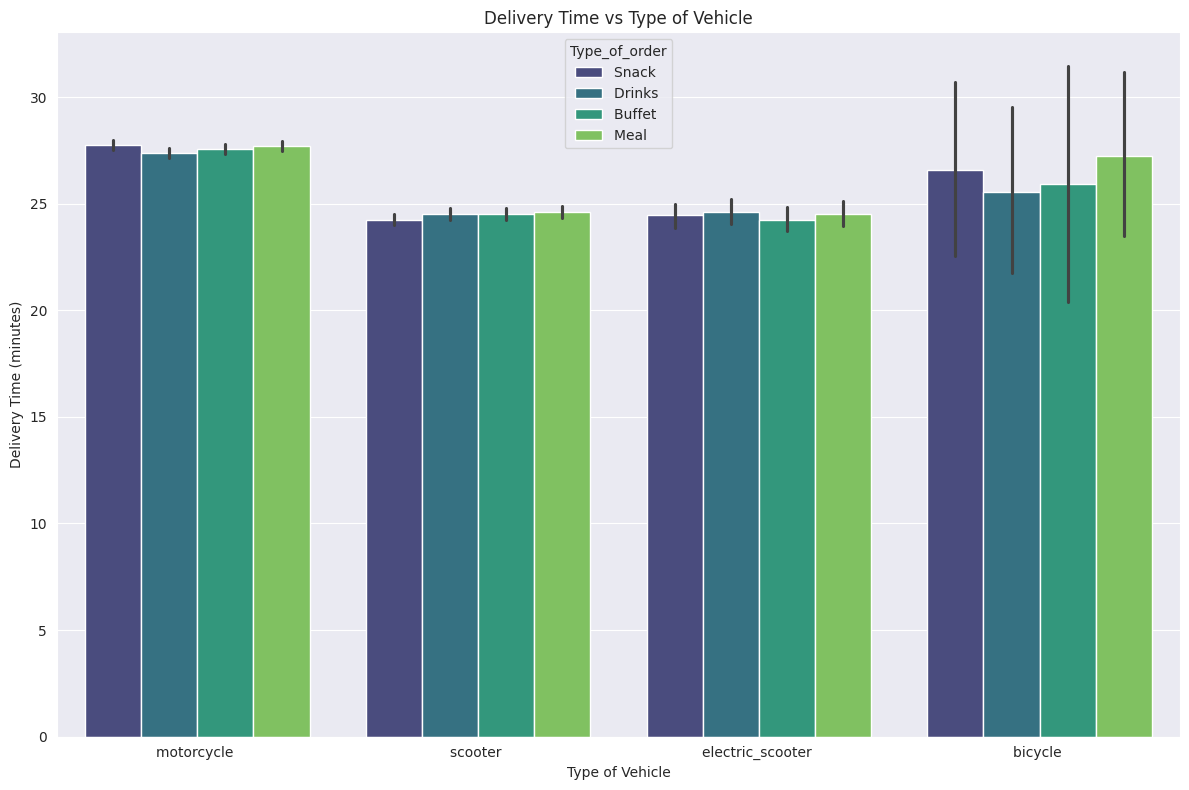

In [10]:
sns.barplot(df, x='Type_of_vehicle', y='Time_taken(min)', hue='Type_of_order', palette='viridis')
plt.title('Delivery Time vs Type of Vehicle')
plt.xlabel('Type of Vehicle')
plt.ylabel('Delivery Time (minutes)')
plt.tight_layout()

Display the box plot for type of vehicle and delivery time to see the outliers

In [11]:
px.box(
    df,
    x="Type_of_vehicle",
    y="Time_taken(min)",
    color="Type_of_order",
    title='Type of Vehicle Delivery Time Box plot'
)

Display the area plot for delivery person ratings and delivery time.

We can see that the delivery time is getting shorter as the delivery person ratings increase. Also, the delivery time is getting shorter as the type of vehicle is getting better.

In [12]:
px.area(
    df,
    x='Delivery_person_Ratings',
    y='Time_taken(min)',
    color='Type_of_vehicle',
    title='Delivery Time vs Delivery Person Ratings'
)

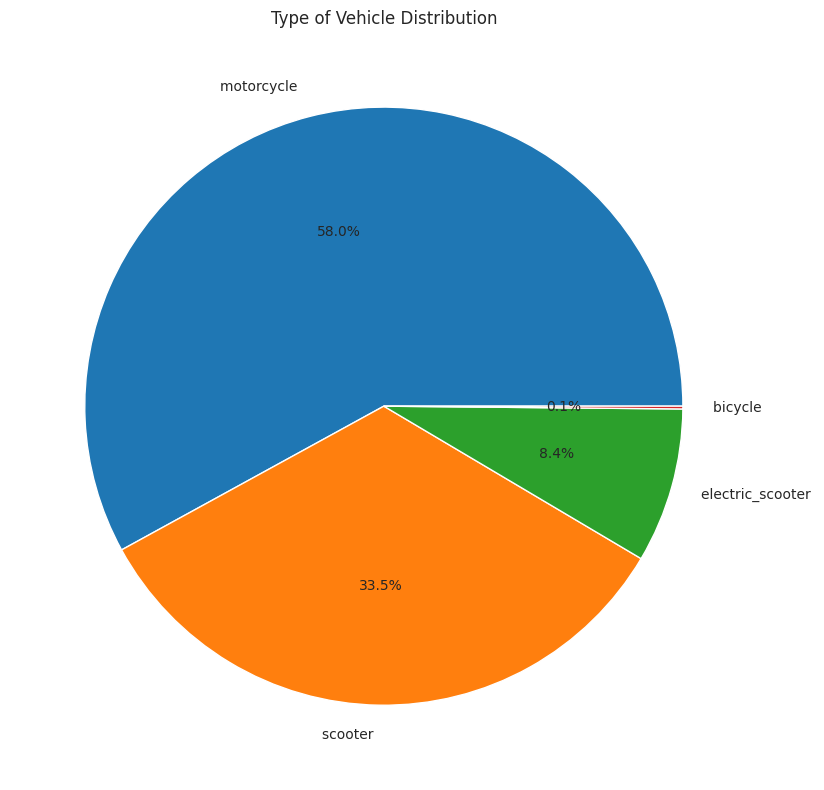

In [13]:
df['Type_of_vehicle'].value_counts().plot.pie(autopct='%1.1f%%', title='Type of Vehicle Distribution')
plt.ylabel('')
plt.tight_layout()

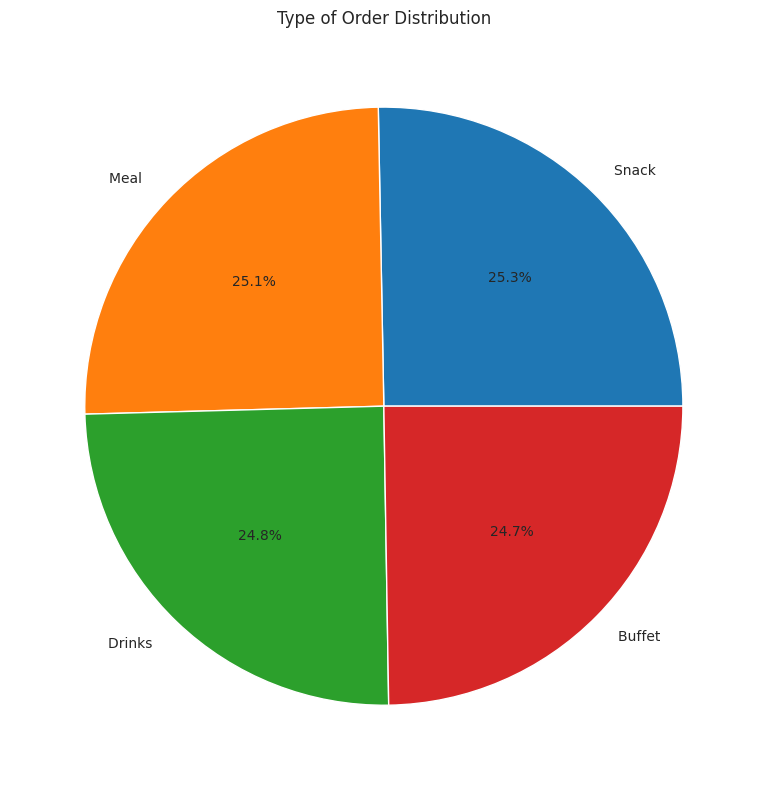

In [14]:
df['Type_of_order'].value_counts().plot.pie(autopct='%1.1f%%', title='Type of Order Distribution')
plt.ylabel('')
plt.tight_layout()

Let's see the total deliveries for each delivery person

In [43]:
# Count total deliveries for each delivery person
delivery_counts = df.groupby('Delivery_person_ID').size().reset_index(name='Total_Deliveries')

# Sort by total deliveries in descending order
delivery_counts = delivery_counts.sort_values('Total_Deliveries', ascending=False)

print("Total deliveries for each delivery person:")
print(delivery_counts.head(10))  # Show top 10 delivery persons

print(f"\nTotal number of unique delivery persons: {len(delivery_counts)}")
print(f"Average deliveries per person: {delivery_counts['Total_Deliveries'].mean():.2f}")
print(f"Maximum deliveries by a single person: {delivery_counts['Total_Deliveries'].max()}")
print(f"Minimum deliveries by a single person: {delivery_counts['Total_Deliveries'].min()}")

Total deliveries for each delivery person:
     Delivery_person_ID  Total_Deliveries
691       JAPRES11DEL02                67
1083     PUNERES01DEL01                67
1146   RANCHIRES02DEL01                66
1285      VADRES08DEL02                66
669       JAPRES03DEL01                66
1291      VADRES11DEL02                66
553       HYDRES04DEL02                66
688       JAPRES09DEL02                65
1147   RANCHIRES02DEL02                65
1290      VADRES11DEL01                65

Total number of unique delivery persons: 1320
Average deliveries per person: 34.54
Maximum deliveries by a single person: 67
Minimum deliveries by a single person: 5


Visualize the distribution of deliveries per person

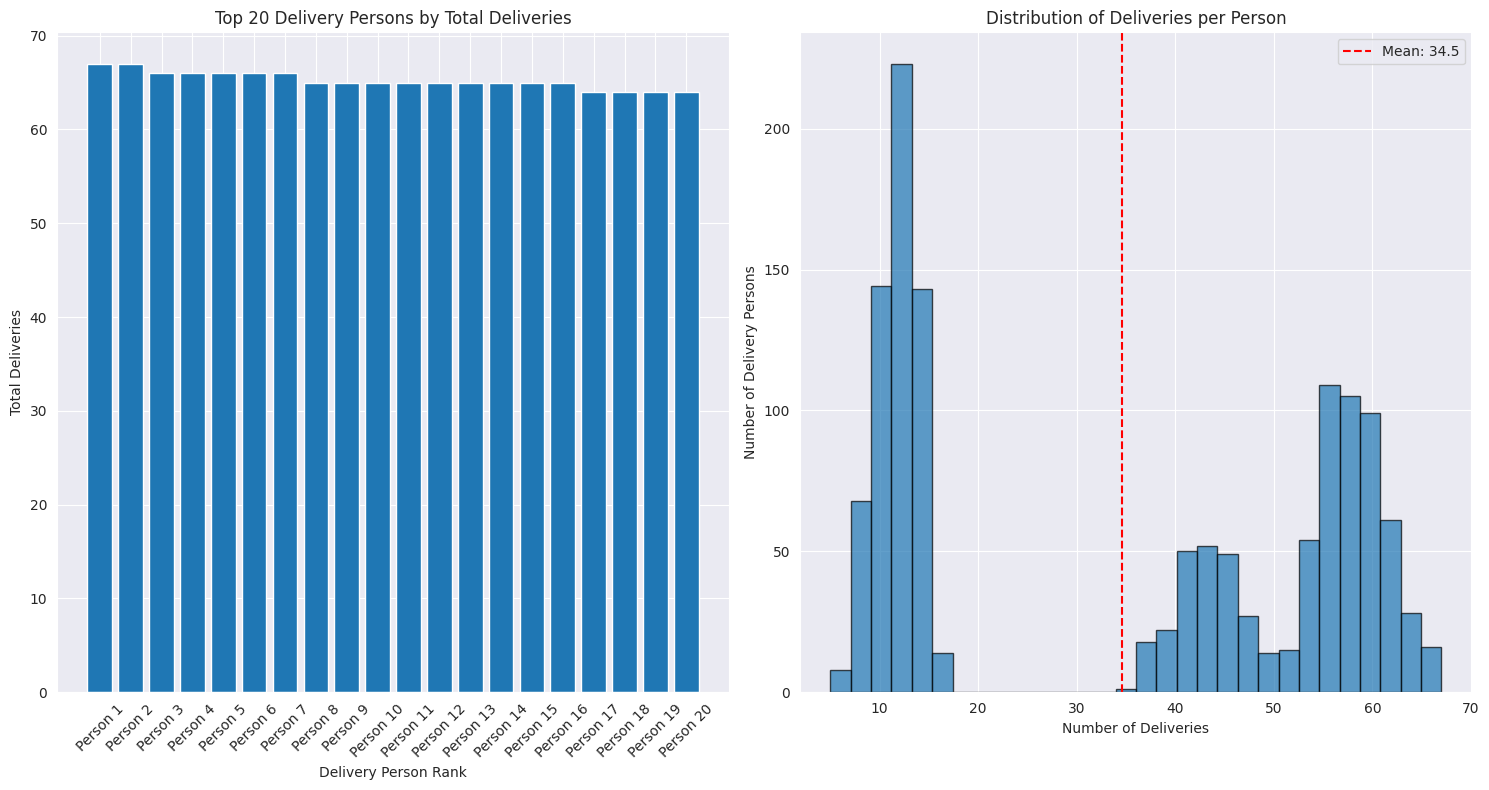

In [45]:
plt.figure(figsize=(15, 8))

# Subplot 1: Top 20 delivery persons
plt.subplot(1, 2, 1)
top_20 = delivery_counts.head(20)
plt.bar(range(len(top_20)), top_20['Total_Deliveries'])
plt.title('Top 20 Delivery Persons by Total Deliveries')
plt.xlabel('Delivery Person Rank')
plt.ylabel('Total Deliveries')
plt.xticks(range(len(top_20)), [f"Person {i+1}" for i in range(len(top_20))], rotation=45)

# Subplot 2: Distribution histogram
plt.subplot(1, 2, 2)
plt.hist(delivery_counts['Total_Deliveries'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Deliveries per Person')
plt.xlabel('Number of Deliveries')
plt.ylabel('Number of Delivery Persons')
plt.axvline(delivery_counts['Total_Deliveries'].mean(), color='red', linestyle='--', 
           label=f'Mean: {delivery_counts["Total_Deliveries"].mean():.1f}')
plt.legend()

plt.tight_layout()

## 4. Feature Engineering
We'll transform raw data into meaningful features for our model: calculating delivery distances from coordinates, group the dlivery persons and find the total delivery.

### Distance Calculation using the [Haversine Formula](https://en.wikipedia.org/wiki/Haversine_formula)

Our dataset contains separate latitude and longitude coordinates for restaurants and delivery locations, but lacks a direct distance measurement. The Haversine formula provides an accurate method to compute the great-circle distance between two points on Earth's surface using their geographic coordinates.

<div align="center">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Illustration_of_great-circle_distance.svg/250px-Illustration_of_great-circle_distance.svg.png">
</div>

**Mathematical Formula:**

 $$d = 2r \arcsin\left(\sqrt{\sin^2\left(\frac{\Delta\phi}{2}\right) + \cos(\phi_1)\cos(\phi_2)\sin^2\left(\frac{\Delta\lambda}{2}\right)}\right)$$

Where:
 - $d$ = distance between the two points
 - $r$ = radius of the Earth (6,371 km)
 - $\phi_1, \phi_2$ = latitudes of point 1 and point 2
 - $\Delta\phi = \phi_2 - \phi_1$ = difference in latitudes
 - $\Delta\lambda = \lambda_2 - \lambda_1$ = difference in longitudes

This formula accounts for Earth's curvature and provides precise distance measurements essential for accurate delivery time predictions.

In [15]:
# Set the earth's radius (in kilometers)
R = 6371

# Convert degrees to radians
def deg_to_rad(degrees):
    return degrees * (np.pi/180)

# Calculate the distance between two points
def calculate_distance(lat1, lon1, lat2, lon2):
    d_lat = deg_to_rad(lat2 - lat1)
    d_lon = deg_to_rad(lon2 - lon1)
    a = np.sin(d_lat/2)**2 + np.cos(deg_to_rad(lat1)) * np.cos(deg_to_rad(lat2)) * np.sin(d_lon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

Adding distance column to the dataframe with calculation of distance between restaurant and delivery location

In [16]:
df['Distance'] = calculate_distance(
    df['Restaurant_latitude'], 
    df['Restaurant_longitude'], 
    df['Delivery_location_latitude'], 
    df['Delivery_location_longitude']
)

Let's plot the time taken vs distance

In [17]:
px.scatter(df, x='Distance', y='Time_taken(min)', color='Type_of_order', title='Time Taken vs Distance')

### Delivery Person Performance Analysis
We'll create a new column with order counts per delivery person to analyze performance and identify the most active delivery partners.

In [18]:
# Group by delivery person ID
dp_group = df.groupby('Delivery_person_ID')

Let's display the metrics for each delivery person. That is the order count, mean, std, min, max of time taken and distance.

In [19]:
dp_group.agg({
    'Time_taken(min)': ['size', 'mean', 'std', 'min', 'max'],
    'Distance': ['mean', 'std', 'min', 'max']
}).sort_values(('Time_taken(min)', 'size'), ascending=False)

Time_taken(min)                                 Distance  \
                              size       mean        std min max       mean   
Delivery_person_ID                                                            
JAPRES11DEL02                   67  28.597015   8.898518  14  45  10.649472   
PUNERES01DEL01                  67  27.925373   8.970175  12  48   8.848862   
RANCHIRES02DEL01                66  26.924242   8.922419  10  53   8.625108   
VADRES08DEL02                   66  25.075758   9.657696  11  52  11.245996   
JAPRES03DEL01                   66  27.030303  10.323937  10  53   8.508601   
...                            ...        ...        ...  ..  ..        ...   
AURGRES11DEL03                   7  28.571429  13.818552  11  44  10.109144   
GOARES01DEL03                    7  26.142857   6.309479  21  39   9.262810   
KOCRES16DEL03                    6  21.000000   4.000000  17  27   9.363264   
KOLRES09DEL03                    6  31.500000   3.619392  28  38  10.595169   
BHPRES010DEL03                   5  30.000000   9.669540  21  45   8.152833   

                                                   
                         std       min        max  
Delivery_person_ID                                 
JAPRES11DEL02       6.213170  2.979626  19.363383  
PUNERES01DEL01      5.743091  1.532126  16.851045  
RANCHIRES02DEL01    5.734847  1.572534  17.297866  
VADRES08DEL02       6.381655  3.145067  20.442930  
JAPRES03DEL01       5.680795  1.489781  16.384367  
...                      ...       ...        ...  
AURGRES11DEL03      4.244592  4.717601  14.152801  
GOARES01DEL03       3.781298  4.631614  13.893865  
KOCRES16DEL03       4.187220  4.681775  14.044683  
KOLRES09DEL03       3.707234  4.541144  13.622067  
BHPRES010DEL03      3.789186  4.529611  13.587431  

[1320 rows x 9 columns]

In [20]:
df['Total_orders'] = dp_group['Time_taken(min)'].transform('size')

### Dtypes conversion
Let's convert the dtypes of the columns to the appropriate dtypes.

In [21]:
df = df.astype({
    'Type_of_vehicle': 'category',
    'Type_of_order': 'category'
})

## 5. Data Preprocessing
Before training our machine learning model, we need to preprocess the data and seperate features and target variable.

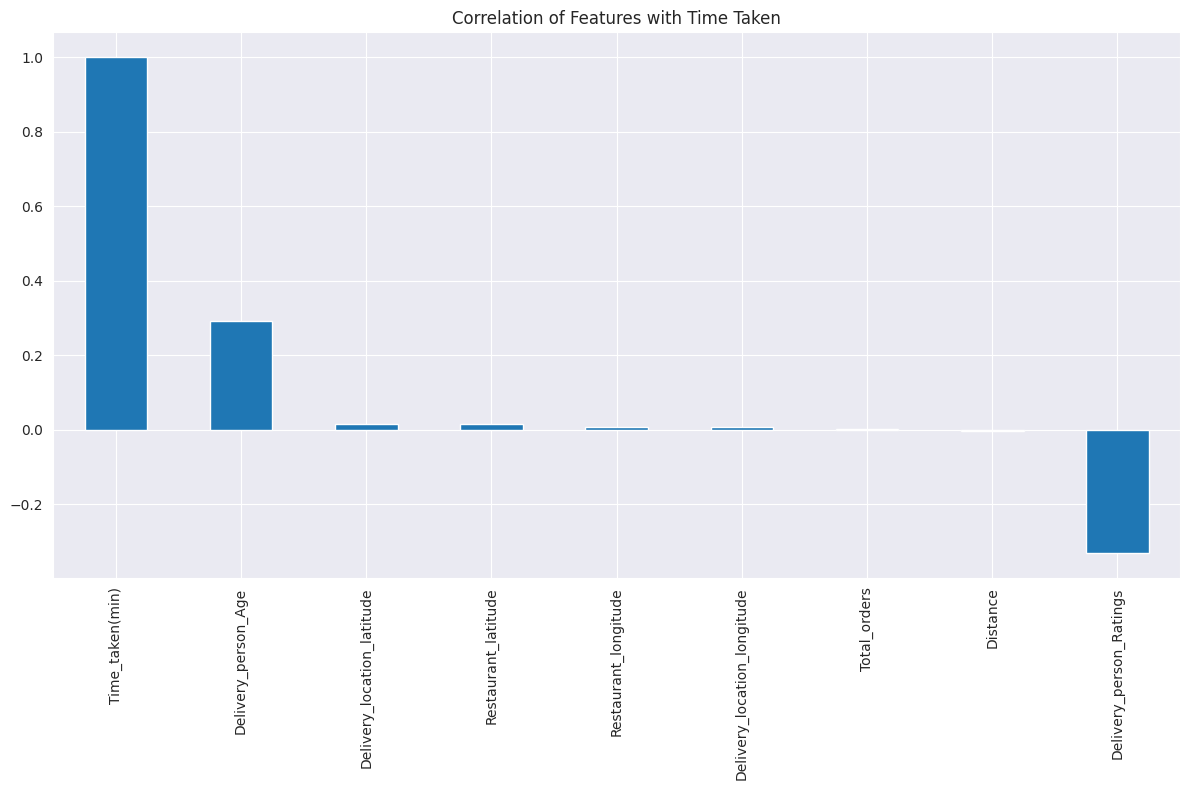

In [22]:
df.corr(numeric_only=True)['Time_taken(min)'].sort_values(ascending=False).plot.bar()
plt.title('Correlation of Features with Time Taken')
plt.tight_layout()

In [23]:
x = df.drop([
    'ID', 'Delivery_person_ID', 
    'Time_taken(min)', 'Restaurant_latitude', 
    'Restaurant_longitude', 'Delivery_location_latitude', 
    'Delivery_location_longitude', 'Total_orders'], 
    axis=1)
y = df['Time_taken(min)']

One-Hot encode the categorical features

In [24]:
x_dummies = pd.get_dummies(x)

Scale the numerical features with `MinMaxScaler`

In [25]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_dummies)

Split the data into training and testing sets

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

## 6. Modeling & Evaluation
Train and evaluate multiple regression models for food delivery time prediction.

Define a reusable helper function that fits various regression models on the training data, predicts on train/test, computes MSE, RMSE, and R².

In [27]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "ExtraTreeRegressor": ExtraTreeRegressor(),
    "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=5),
    "LightGBM": lgb.LGBMRegressor(verbose=0),
    "XGBoost": xgb.XGBRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "RandomForestRegressor": RandomForestRegressor()
}


def evaluate(x_train, y_train, x_test, y_test):
    results = []
    for name, model in tqdm(models.items()):
        print(f"Training {name} model...")
        y_pred = model.fit(x_train, y_train).predict(x_test)
        
        results.append({
            "Model": name,
            "R2_Score": r2_score(y_test, y_pred),
            "MSE": mean_squared_error(y_test, y_pred),
            "RMSE": mean_squared_error(y_test, y_pred)**0.5
        })
    report = pd.DataFrame(results).sort_values('R2_Score', ascending=False)
    report.reset_index(drop=True, inplace=True)
    return report

Evaluate the performance of the models

In [28]:
result_df = evaluate(x_train, y_train, x_test, y_test)
result_df

  0%|          | 0/10 [00:00<?, ?it/s]

Training LinearRegression model...
Training Ridge model...
Training Lasso model...
Training DecisionTreeRegressor model...
Training ExtraTreeRegressor model...
Training KNeighborsRegressor model...
Training LightGBM model...
Training XGBoost model...
Training GradientBoostingRegressor model...
Training RandomForestRegressor model...


Model  R2_Score         MSE       RMSE
0                   LightGBM  0.408562   51.856139   7.201121
1  GradientBoostingRegressor  0.406230   52.060685   7.215309
2                    XGBoost  0.388226   53.639202   7.323879
3      RandomForestRegressor  0.321889   59.455548   7.710742
4        KNeighborsRegressor  0.268070   64.174234   8.010882
5                      Ridge  0.202596   69.914924   8.361514
6           LinearRegression  0.202559   69.918165   8.361708
7                      Lasso -0.000014   87.679364   9.363726
8      DecisionTreeRegressor -0.194054  104.692449  10.231933
9         ExtraTreeRegressor -0.199350  105.156815  10.254600

### Training a deep learning model
Train an LSTM-based deep learning model and compare its performance against traditional machine learning models using multiple evaluation metrics.

Import necessary libraries

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping

No need to scale the data for LSTM model, we can split the data into train and test with one-hot encoded data

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x_dummies, y, test_size=0.2, random_state=42)

Build the LSTM model

In [42]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.5),
    LSTM(32, return_sequences=False),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

model.compile(optimizer='sgd', loss='mean_squared_error')

Define callback for early stopping to prevent overfitting

In [32]:
callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True,
        verbose=1
        )
]

Now, let's train the model

In [33]:
history = model.fit(
    x_train, y_train, 
    epochs=100, 
    batch_size=256, 
    validation_data=(x_test, y_test), 
    callbacks=callbacks
)

Epoch 1/100


2025-09-05 18:22:45.428965: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200


143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 195.3970 - val_loss: 91.2849
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 99.4761 - val_loss: 88.5923
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 94.6309 - val_loss: 87.9884
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 91.5018 - val_loss: 87.8718
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 90.4825 - val_loss: 87.6764
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 89.3217 - val_loss: 87.7533
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 88.7384 - val_loss: 87.7458
Epoch 8/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 88.4898 - val_loss: 87.3772
Epoch 9/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 87.5154 - val_loss: 85.7469
Epoch 10/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 83.6955 - val_loss: 94.6838
Epoch 11/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 81.5292 - val_loss: 82.1685
Epoch 12/100
143/14

Plot the training history

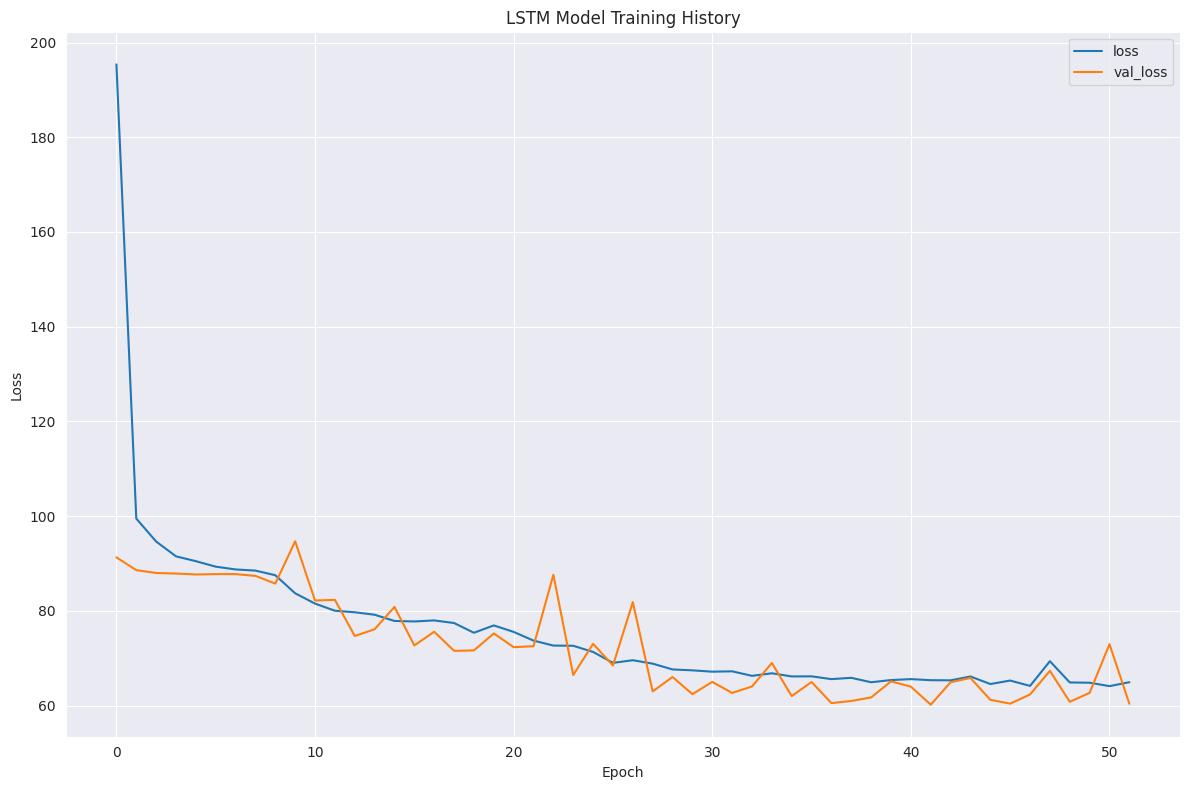

In [34]:
pd.DataFrame(history.history).plot()
plt.title('LSTM Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

In [35]:
y_pred = model.predict(x_test, verbose=0)
print(f"R2 Score : {r2_score(y_test, y_pred)}")
print(f"MSE      : {mean_squared_error(y_test, y_pred)}")
print(f"RMSE     : {mean_squared_error(y_test, y_pred)**0.5}")


R2 Score : 0.31370025873184204
MSE      : 60.173484802246094
RMSE     : 7.7571570051305585


While the LSTM model shows decent performance, LightGBM achieves superior results for this dataset. Although further hyperparameter tuning could potentially improve the deep learning model, LightGBM provides the optimal balance of performance and efficiency for our food delivery time prediction task.

## 7. Model Saving
Build a model pipeline and save it for inference.

In [36]:
preprocessor = ColumnTransformer([
    ('scaler', MinMaxScaler(), x.select_dtypes(include=['number']).columns),
    ('encoder', OneHotEncoder(), x.select_dtypes(include=['category']).columns)
])

In [37]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMRegressor(verbose=-1))
])

In [38]:
pipeline.fit(x, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Distance'], dtype='object')),
                                                 ('encoder', OneHotEncoder(),
                                                  Index(['Type_of_order', 'Type_of_vehicle'], dtype='object'))])),
                ('model', LGBMRegressor(verbose=-1))])

Evaluate the model pipeline

In [39]:
y_pred = pipeline.predict(x)
print(f"R2 Score : {r2_score(y, y_pred)}")
print(f"MSE      : {mean_squared_error(y, y_pred)}")
print(f"RMSE     : {mean_squared_error(y, y_pred)**0.5}")

R2 Score : 0.43662684996222556
MSE      : 49.60719536825707
RMSE     : 7.043237562957611


Save the model pipeline

In [40]:
joblib.dump(pipeline, 'food_delivery_time_prediction_model.pkl')

['food_delivery_time_prediction_model.pkl']

## 8. Conclusion

This project developed a comprehensive machine learning pipeline to predict food delivery times using a dataset of 45,593 delivery records. The analysis encompassed exploratory data analysis, feature engineering, and extensive model evaluation to identify the optimal approach for delivery time estimation.

**Data Analysis & Feature Engineering:**
The dataset contained delivery person demographics, geographic coordinates, order types, and vehicle information. Key insights revealed that delivery times correlate strongly with distance (calculated using the Haversine formula), delivery person ratings, and vehicle type. Feature engineering included distance calculation between restaurant and delivery locations, delivery person performance metrics, and proper encoding of categorical variables.

**Model Performance:**
We evaluated 10 different algorithms, with LightGBM achieving the best performance (R² = 0.409, RMSE = 7.20 minutes), followed by Gradient Boosting (R² = 0.406) and XGBoost (R² = 0.388). An LSTM deep learning model was also tested but performed significantly worse (R² = 0.314), confirming that tree-based methods are more suitable for this tabular data problem.

**Key Findings:**
- Distance is the primary driver of delivery time, with clear linear relationships observed
- Delivery person ratings show inverse correlation with delivery times (higher ratings = faster delivery)
- Vehicle type significantly impacts performance, with motorcycles and scooters being most efficient
- Order type (Snack, Meal, Drinks, Buffet) shows distinct delivery time patterns

**Technical Implementation:**
The final pipeline incorporates MinMaxScaler for numerical features, OneHotEncoder for categorical variables, and the optimized LightGBM model, all packaged using scikit-learn's Pipeline for seamless deployment.

**Limitations & Future Work:**
- The dataset lacks temporal features (time of day, day of week, weather conditions)
- No traffic data or road network information was available
- Hyperparameter optimization could further improve model performance
- Real-time model monitoring and retraining strategies need implementation

**Business Impact:**
This model provides accurate delivery time estimates that can enhance customer experience, optimize delivery routes, and improve operational efficiency for food delivery platforms. The pipeline is production-ready and can be integrated into mobile applications or delivery management systems.

The project demonstrates a complete machine learning workflow from data exploration to model deployment, showcasing best practices in feature engineering, model selection, and pipeline construction for real-world applications.